# K-Nearest Neighbors (KNN) Classification for Neuro and Cancer Datasets  
**ML for Scientists Project**: _Prediction of Disease Type Based on Underlying Mechanisms: Gene Expression versus Post-Transcriptional Drivers_ 

---

### **Overview of Workflow**

---

#### **Preprocessing (for Both Neuro and Cancer Datasets)**
- Load `train.csv` and `test.csv` datasets for each condition (e.g., `train_Neuro.csv`, `test_Neuro.csv`).
- Encode disease labels using `LabelEncoder`.
- One-hot encode categorical metadata (`cell_type`, `tissue`) using `OneHotEncoder`.
- Separate metadata columns (`donor_id`, `cell_type`, `tissue`, `sex`, `disease`, `development_stage`) from gene expression features.
- Concatenate gene expression features with one-hot encoded metadata features.
- Standardize **only** the gene expression features using `StandardScaler`.

---

#### **Donor-Aware Train/Test Split**
- Datasets are already split into training and testing sets.
- Use `donor_id` column to group samples by donor for proper cross-validation.
- Ensures:
  - No leakage of donor identity between training and test sets.
  - Stratification by disease labels is preserved.

---

#### **Group-Aware Cross-Validation + Hyperparameter Tuning**
- Apply `StratifiedGroupKFold` (5 folds) on the training set.
- Use group-aware, label-stratified folds to prevent data leakage.
- For `k` values from 1 to 20:
  - Run KNN classification using a custom `knn_predict` function.
  - Evaluate average accuracy across folds.
- Select the `k` that yields the highest mean cross-validation accuracy.

---

#### **Final Model Training**
- Using the best `k`, retrain KNN on the full training set.
- Use `knn_predict` and `knn_predict_proba` for:
  - Label prediction
  - Class probability estimation

---

#### **Final Evaluation on Held-Out Test Set**
- Evaluate using:
  - Accuracy, precision, recall, and F1-score (`classification_report`)
  - Confusion matrix (with intuitive disease labels)
  - Multiclass ROC-AUC score (macro-average)
  - Per-class ROC curves (`RocCurveDisplay`)

---

### **Model Characteristics**
- **Memory-based learner**: No parameter optimization.
- **Deterministic**: Predictions based on nearest labeled points.
- **Interpretable**: Transparent influence from training data.
- **Drawback**: Computational cost scales poorly with data size.

---

### **Notes on Standardization**
- Gene expression features are standardized (z-scored) using `StandardScaler`.
- Fit scaler on training set gene features only.
- Apply the same transformation to:
  - Validation folds during cross-validation.
  - Test set during final evaluation.
- Categorical features are left untouched after encoding.
- Avoids **data leakage** by separating train/test preprocessing statistics.


In [1]:
# Imports

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (accuracy_score, precision_score,
                             classification_report, ConfusionMatrixDisplay,
                             confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

### KNN Functions

In [3]:
# KNN Functions

def knn_predict(X_train, y_train, X_test, k=5):
    """
    Predict class labels for test data using a basic K-Nearest Neighbors approach.

    Parameters:
        X_train (np.ndarray): Training feature matrix of shape (n_samples_train, n_features).
        y_train (np.ndarray): Training labels of shape (n_samples_train,).
        X_test (np.ndarray): Test feature matrix of shape (n_samples_test, n_features).
        k (int): Number of nearest neighbors to use for classification.

    Returns:
        np.ndarray: Predicted class labels for X_test of shape (n_samples_test,).
    """
    predictions = []
    for test_point in tqdm(X_test):
        distances = np.linalg.norm(X_train - test_point, axis=1)
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        predictions.append(Counter(k_nearest_labels).most_common(1)[0][0])
    return np.array(predictions)

def knn_predict_proba(X_train, y_train, X_test, k=5, n_classes=None):
    """
    Predict class probabilities for test data using a basic K-Nearest Neighbors approach.

    Parameters:
        X_train (np.ndarray): Training feature matrix of shape (n_samples_train, n_features).
        y_train (np.ndarray): Training labels of shape (n_samples_train,).
        X_test (np.ndarray): Test feature matrix of shape (n_samples_test, n_features).
        k (int): Number of nearest neighbors to use for probability estimation.
        n_classes (int, optional): Total number of classes. If None, inferred from y_train.

    Returns:
        np.ndarray: Predicted class probabilities for X_test of shape (n_samples_test, n_classes).
    """
    
    if n_classes is None:
        n_classes = np.max(y_train) + 1
    proba = []
    for test_point in tqdm(X_test, desc="KNN Probabilities"):
        distances = np.linalg.norm(X_train - test_point, axis=1)
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_indices]
        votes = np.zeros(n_classes)
        for label in k_nearest_labels:
            votes[label] += 1
        proba.append(votes / k)
    return np.array(proba)

### ND Dataset

Tuning number of neighbors (k)...


100%|██████████| 127/127 [00:01<00:00, 124.39it/s]


k = 1, Avg CV Accuracy = 0.2413


100%|██████████| 127/127 [00:01<00:00, 119.53it/s]


k = 2, Avg CV Accuracy = 0.2413


100%|██████████| 127/127 [00:01<00:00, 109.06it/s]


k = 3, Avg CV Accuracy = 0.2382


100%|██████████| 127/127 [00:01<00:00, 113.26it/s]


k = 4, Avg CV Accuracy = 0.2369


100%|██████████| 127/127 [00:01<00:00, 84.42it/s]


k = 5, Avg CV Accuracy = 0.2370


100%|██████████| 127/127 [00:01<00:00, 84.80it/s]


k = 6, Avg CV Accuracy = 0.2236


100%|██████████| 127/127 [00:01<00:00, 101.92it/s]


k = 7, Avg CV Accuracy = 0.2159


100%|██████████| 127/127 [00:01<00:00, 75.86it/s]


k = 8, Avg CV Accuracy = 0.2301


100%|██████████| 127/127 [00:02<00:00, 60.29it/s]


k = 9, Avg CV Accuracy = 0.2511


100%|██████████| 127/127 [00:01<00:00, 68.90it/s]


k = 10, Avg CV Accuracy = 0.2296


100%|██████████| 127/127 [00:01<00:00, 71.47it/s]


k = 11, Avg CV Accuracy = 0.2300


100%|██████████| 127/127 [00:02<00:00, 58.73it/s]


k = 12, Avg CV Accuracy = 0.2381


100%|██████████| 127/127 [00:02<00:00, 54.24it/s]


k = 13, Avg CV Accuracy = 0.2223


100%|██████████| 127/127 [00:02<00:00, 55.49it/s]


k = 14, Avg CV Accuracy = 0.2141


100%|██████████| 127/127 [00:01<00:00, 73.20it/s]


k = 15, Avg CV Accuracy = 0.2094


100%|██████████| 127/127 [00:01<00:00, 94.78it/s]


k = 16, Avg CV Accuracy = 0.2101


100%|██████████| 127/127 [00:01<00:00, 92.21it/s]


k = 17, Avg CV Accuracy = 0.1867


100%|██████████| 127/127 [00:01<00:00, 70.25it/s]


k = 18, Avg CV Accuracy = 0.2036


100%|██████████| 127/127 [00:01<00:00, 74.24it/s]


k = 19, Avg CV Accuracy = 0.2010


100%|██████████| 127/127 [00:02<00:00, 58.11it/s]


k = 20, Avg CV Accuracy = 0.1870
Best k found: 9 with average CV accuracy: 0.2511


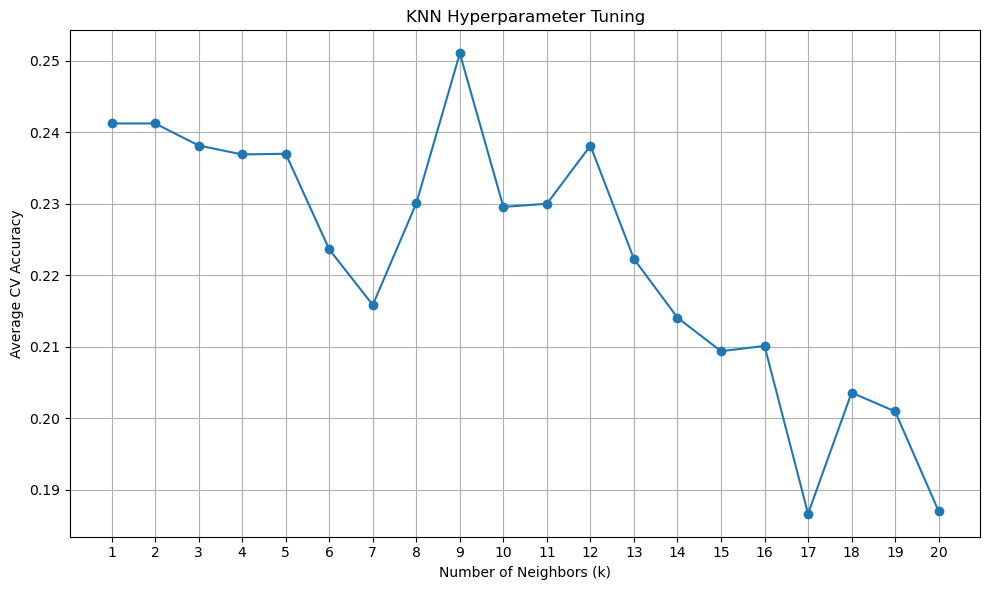

KNN Probabilities: 100%|██████████| 191/191 [00:03<00:00, 59.44it/s]


Final Test Set Classification Reports
KNN Classification Report:
                                precision    recall  f1-score   support

             Alzheimer disease       0.33      0.31      0.32        48
                  Pick disease       0.22      0.27      0.25        48
                        normal       0.57      0.53      0.55        47
progressive supranuclear palsy       0.32      0.29      0.30        48

                      accuracy                           0.35       191
                     macro avg       0.36      0.35      0.36       191
                  weighted avg       0.36      0.35      0.35       191



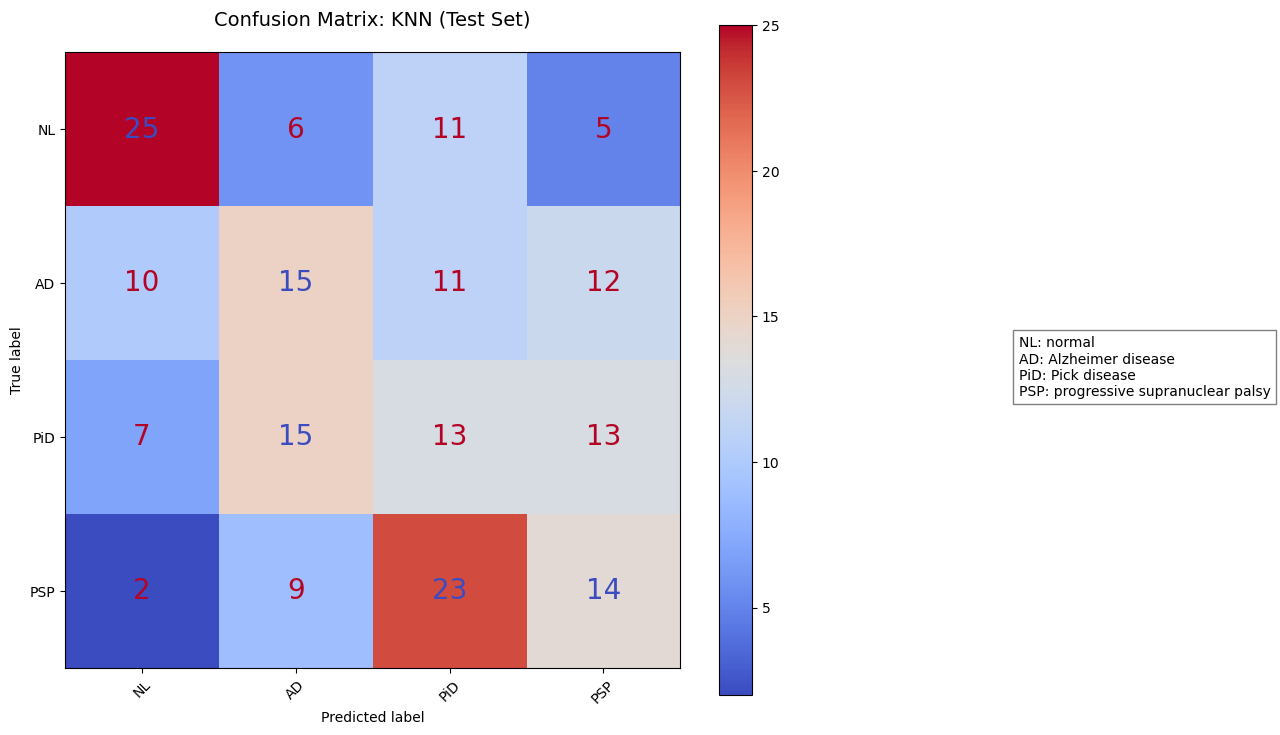


KNN ROC-AUC (macro-average): 0.5956


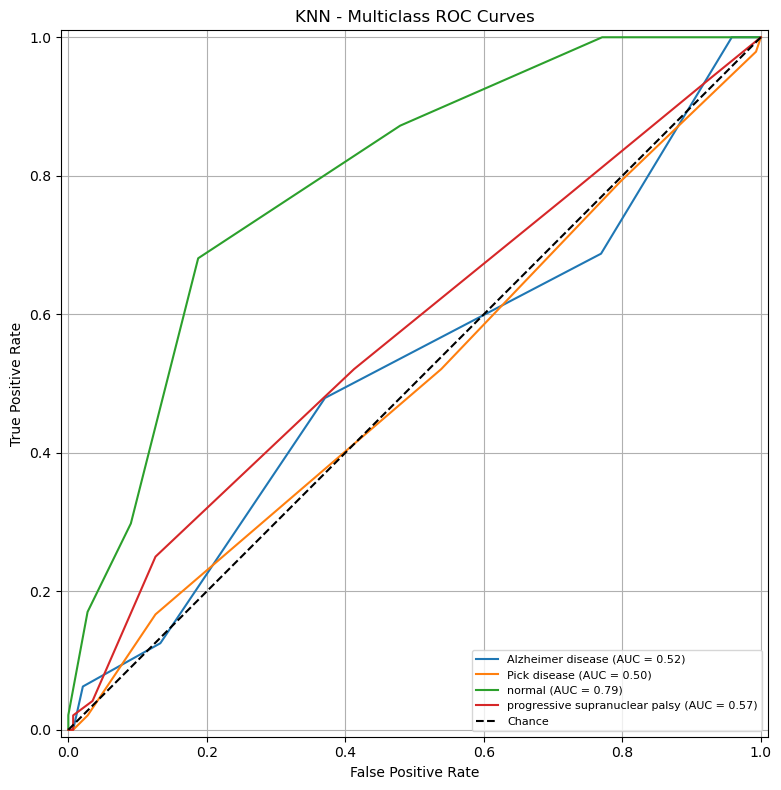

In [9]:
# Dataset 1: Neurodegenerative Disease (ND) Dataset

# 1. Load and Preprocess Data

train_df = pd.read_csv("../data/train_neuro.csv")
test_df = pd.read_csv("../data/test_neuro.csv")

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["disease"])
y_test = label_encoder.transform(test_df["disease"])
groups_train = train_df["donor_id"]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded_train = encoder.fit_transform(train_df[["cell_type", "tissue"]])
cat_encoded_test = encoder.transform(test_df[["cell_type", "tissue"]])

# Select only gene expression features
meta_cols = ["donor_id", "cell_type", "tissue", "sex", "disease", "development_stage"]
gene_expr_train = train_df.drop(columns=[col for col in meta_cols if col in train_df.columns])
gene_expr_test = test_df.drop(columns=[col for col in meta_cols if col in test_df.columns])

# Final feature matrix
X_train_full = np.hstack([gene_expr_train.values, cat_encoded_train])
X_test_full = np.hstack([gene_expr_test.values, cat_encoded_test])

# Standardize gene expression features only
n_gene_features = gene_expr_train.shape[1]
scaler = StandardScaler()
X_train_full[:, :n_gene_features] = scaler.fit_transform(X_train_full[:, :n_gene_features])
X_test_full[:, :n_gene_features] = scaler.transform(X_test_full[:, :n_gene_features])


# 2. Hyperparameter Tuning (with CV)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
k_values = list(range(1, 21))
k_accuracies = []

print("Tuning number of neighbors (k)...")
for k in k_values:
    fold_accuracies = []
    for train_idx, val_idx in sgkf.split(X_train_full, y_train, groups_train):
        X_tr, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        preds = knn_predict(X_tr, y_tr, X_val, k=k)
        acc = accuracy_score(y_val, preds)
        fold_accuracies.append(acc)
    avg_acc = np.mean(fold_accuracies)
    k_accuracies.append(avg_acc)
    print(f"k = {k}, Avg CV Accuracy = {avg_acc:.4f}")

best_k = k_values[np.argmax(k_accuracies)]
print(f"Best k found: {best_k} with average CV accuracy: {max(k_accuracies):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average CV Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# 3. Train Final Model (on best k) + Evaluation
final_knn_preds = knn_predict(X_train_full, y_train, X_test_full, k=best_k)
final_knn_proba = knn_predict_proba(X_train_full, y_train, X_test_full, k=best_k, n_classes=len(label_encoder.classes_))

print("Final Test Set Classification Reports")
print("KNN Classification Report:")
print(classification_report(y_test, final_knn_preds, target_names=label_encoder.classes_))

# 4. Confusion Matrix Plot
def plot_confusion_nd(y_true, y_pred, title):
    label_order = ["normal", "Alzheimer disease", "Pick disease", "progressive supranuclear palsy"]
    short_labels = ["NL", "AD", "PiD", "PSP"]
    label_indices = [np.where(label_encoder.classes_ == name)[0][0] for name in label_order]
    conf_matrix = confusion_matrix(y_true, y_pred, labels=label_indices)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=short_labels)
    disp.plot(cmap=plt.cm.coolwarm, ax=ax, text_kw={'fontsize': 12})

    for text in disp.text_.ravel():
        text.set_fontsize(20)

    plt.title(f"Confusion Matrix: {title}", fontsize=14, pad=20)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    legend_text = "\n".join([f"{abbr}: {full}" for full, abbr in zip(label_order, short_labels)])
    plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va="center",
                   bbox=dict(facecolor="white", edgecolor="gray"))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_confusion_nd(y_test, final_knn_preds, "KNN (Test Set)")

# 5. AUC-ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
knn_auc = roc_auc_score(y_test_bin, final_knn_proba, average="macro", multi_class="ovr")
print(f"\nKNN ROC-AUC (macro-average): {knn_auc:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        final_knn_proba[:, i],
        name=f"{label_encoder.classes_[i]}",
        ax=ax
    )

ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_title("KNN - Multiclass ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right", fontsize=8)
ax.grid(True)
plt.tight_layout()
plt.show()


### Cancer Dataset

Tuning number of neighbors (k)...


100%|██████████| 149/149 [00:01<00:00, 136.11it/s]


k = 1, Avg CV Accuracy = 0.6394


100%|██████████| 149/149 [00:00<00:00, 163.82it/s]


k = 2, Avg CV Accuracy = 0.6394


100%|██████████| 149/149 [00:01<00:00, 118.99it/s]


k = 3, Avg CV Accuracy = 0.6188


100%|██████████| 149/149 [00:01<00:00, 125.34it/s]


k = 4, Avg CV Accuracy = 0.6172


100%|██████████| 149/149 [00:01<00:00, 100.25it/s]


k = 5, Avg CV Accuracy = 0.6001


100%|██████████| 149/149 [00:02<00:00, 72.83it/s]


k = 6, Avg CV Accuracy = 0.6031


100%|██████████| 149/149 [00:01<00:00, 128.68it/s]


k = 7, Avg CV Accuracy = 0.5903


100%|██████████| 149/149 [00:01<00:00, 109.90it/s]


k = 8, Avg CV Accuracy = 0.5880


100%|██████████| 149/149 [00:00<00:00, 175.97it/s]


k = 9, Avg CV Accuracy = 0.5780


100%|██████████| 149/149 [00:00<00:00, 160.04it/s]


k = 10, Avg CV Accuracy = 0.5649


100%|██████████| 149/149 [00:00<00:00, 164.65it/s]


k = 11, Avg CV Accuracy = 0.5495


100%|██████████| 149/149 [00:01<00:00, 110.03it/s]


k = 12, Avg CV Accuracy = 0.5513


100%|██████████| 149/149 [00:01<00:00, 77.44it/s]


k = 13, Avg CV Accuracy = 0.5464


100%|██████████| 149/149 [00:00<00:00, 152.44it/s]


k = 14, Avg CV Accuracy = 0.5341


100%|██████████| 149/149 [00:00<00:00, 165.55it/s]


k = 15, Avg CV Accuracy = 0.5358


100%|██████████| 149/149 [00:00<00:00, 151.63it/s]


k = 16, Avg CV Accuracy = 0.5292


100%|██████████| 149/149 [00:01<00:00, 146.16it/s]


k = 17, Avg CV Accuracy = 0.5240


100%|██████████| 149/149 [00:01<00:00, 113.26it/s]


k = 18, Avg CV Accuracy = 0.5268


100%|██████████| 149/149 [00:01<00:00, 147.39it/s]


k = 19, Avg CV Accuracy = 0.5255


100%|██████████| 149/149 [00:01<00:00, 141.25it/s]


k = 20, Avg CV Accuracy = 0.5236
Best k found: 1 with average CV accuracy: 0.6394


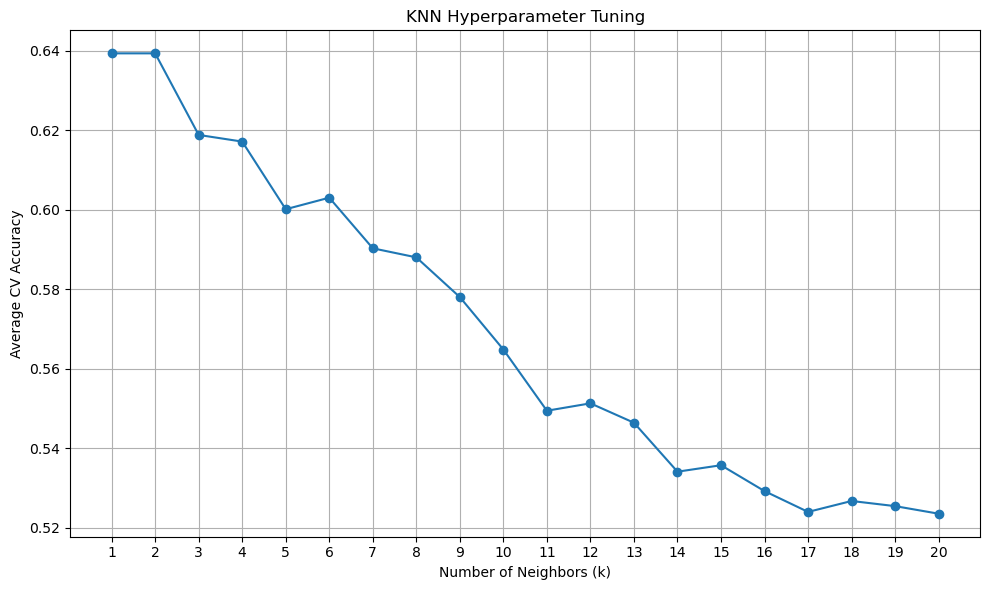

KNN Probabilities: 100%|██████████| 227/227 [00:02<00:00, 91.11it/s] 


Final Test Set Classification Reports
KNN:
                   precision    recall  f1-score   support

    breast cancer       0.68      0.72      0.70        29
colorectal cancer       0.31      0.44      0.36         9
     liver cancer       0.52      0.48      0.50        23
      lung cancer       0.56      0.52      0.54        44
         melanoma       1.00      0.80      0.89        44
           normal       0.60      0.71      0.65        45
   ovarian cancer       0.12      0.20      0.15        10
   uveal melanoma       0.71      0.52      0.60        23

         accuracy                           0.62       227
        macro avg       0.56      0.55      0.55       227
     weighted avg       0.65      0.62      0.63       227



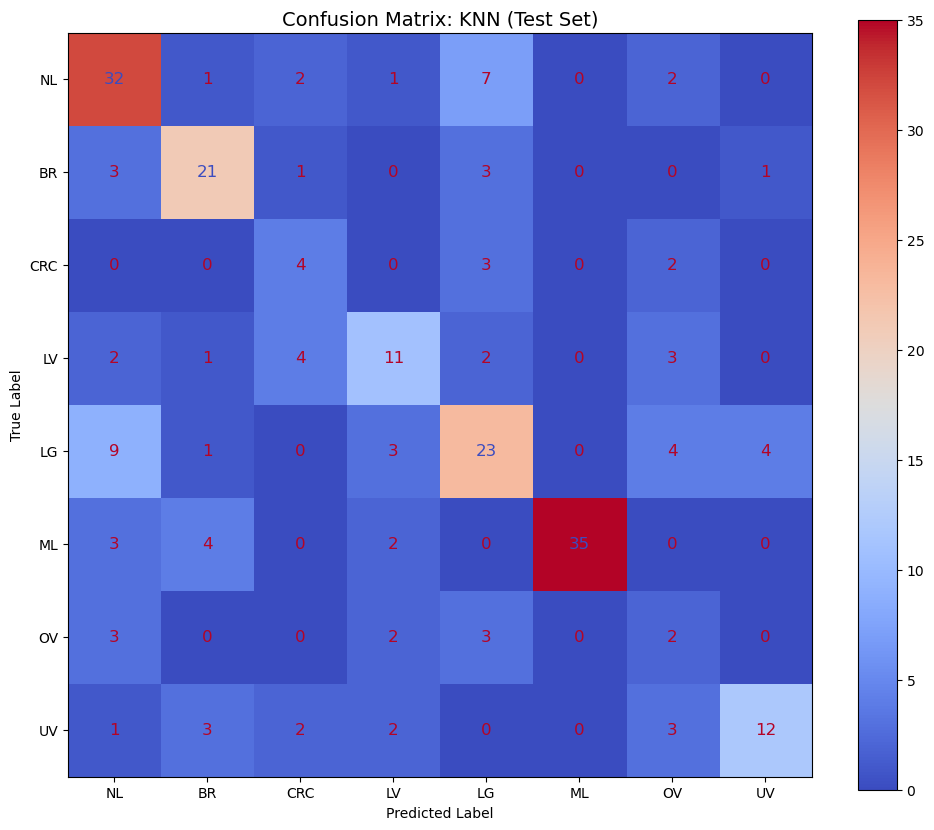


KNN ROC-AUC (macro-average): 0.8296


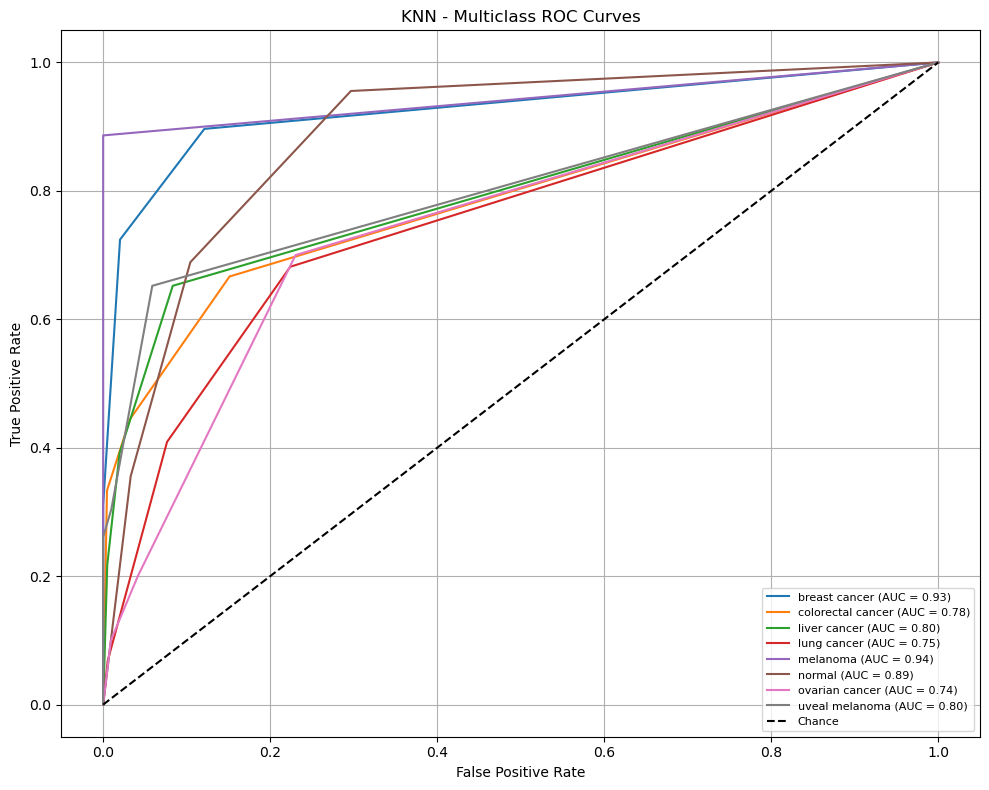

In [4]:
# Dataset 2: Cancer Dataset

# 1. Load and Preprocess Data
train_df = pd.read_csv("../data/train_cancer.csv")
test_df = pd.read_csv("../data/test_cancer.csv")

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["disease"])
y_test = label_encoder.transform(test_df["disease"])
groups_train = train_df["donor_id"]

drop_cols = ["donor_id", "sex", "development_stage", "cell_type", "tissue", "disease"]
X_train_full = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
X_test_full = test_df[X_train_full.columns]  # align columns
X_train_full = X_train_full.values
X_test_full = X_test_full.values

n_gene_features = X_train_full.shape[1]
scaler = StandardScaler()
X_train_full[:, :n_gene_features] = scaler.fit_transform(X_train_full[:, :n_gene_features])
X_test_full[:, :n_gene_features] = scaler.transform(X_test_full[:, :n_gene_features])

# 2. Hyperparameter Tuning (with CV)
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
k_values = list(range(1, 21))
k_accuracies = []

print("Tuning number of neighbors (k)...")
for k in k_values:
    fold_accuracies = []
    for train_idx, val_idx in sgkf.split(X_train_full, y_train, groups_train):
        X_tr, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        preds = knn_predict(X_tr, y_tr, X_val, k=k)
        acc = accuracy_score(y_val, preds)
        fold_accuracies.append(acc)
    avg_acc = np.mean(fold_accuracies)
    k_accuracies.append(avg_acc)
    print(f"k = {k}, Avg CV Accuracy = {avg_acc:.4f}")

best_k = k_values[np.argmax(k_accuracies)]
print(f"Best k found: {best_k} with average CV accuracy: {max(k_accuracies):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average CV Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# 3. Final Test Evaluation
final_k = 3
final_knn_preds = knn_predict(X_train_full, y_train, X_test_full, k=final_k)
final_knn_proba = knn_predict_proba(X_train_full, y_train, X_test_full, k=final_k, n_classes=len(label_encoder.classes_))

print("Final Test Set Classification Reports")
print("KNN:")
print(classification_report(y_test, final_knn_preds, target_names=label_encoder.classes_))

# 4. Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    label_order = ['normal', 'breast cancer', 'colorectal cancer', 
                   'liver cancer', 'lung cancer', 'melanoma',
                   'ovarian cancer', 'uveal melanoma']
    short_labels = ['NL', 'BR', 'CRC', 'LV', 'LG', 'ML', 'OV', 'UV']
    label_indices = [np.where(label_encoder.classes_ == name)[0][0] for name in label_order]
    conf_matrix = confusion_matrix(y_true, y_pred, labels=label_indices)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=short_labels)
    disp.plot(cmap=plt.cm.coolwarm, ax=ax, text_kw={'fontsize': 12})
    plt.title(f"Confusion Matrix: {title}", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion(y_test, final_knn_preds, "KNN (Test Set)")

# 5. AUC-ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

knn_auc = roc_auc_score(y_test_bin, final_knn_proba, average='macro', multi_class='ovr')
print(f"\nKNN ROC-AUC (macro-average): {knn_auc:.4f}")

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_knn_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("KNN - Multiclass ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()
